In [11]:
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi


logging.basicConfig(format='%(message)s', level=logging.INFO)

In [12]:
create_experiment_snapshots([25, 50, 75, 100])

In [13]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 3000
mtd_interval = 100
total_nodes = 300
new_network = True
features = ["host_compromise_ratio", "exposed_endpoints", "attack_path_exposure",  "overall_asr_avg", "roa", "shortest_path_variability", "risk"]
model = "main_network_final_host_compromise_ratio#exposed_endpoints#attack_path_exposure#overall_asr_avg#roa#shortest_path_variability#risk"
trial = 5


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class RadarPlot:
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, total_nodes, new_network, features, model, trial):
        # Learning Parameters
        self.epsilon = epsilon  # exploration rate

        # Simulator Settings
        self.start_time = start_time
        self.finish_time = finish_time
        self.mtd_interval = mtd_interval
        self.schemes = [ 'mtd_ai', 'simultaneous', 'random', 'alternative']
        self.total_nodes = total_nodes
        self.new_network = new_network
        self.features = features
        self.model = model
        self.trial = trial
        self.normalization_values = self.calculate_normalized_values()
        print(self.normalization_values)




    def calculate_normalized_values(self):
        # DataFrame to store the results of each trial
        security_metrics = pd.DataFrame(columns=self.features)

        for _ in range(self.trial):
            # Execute the simulation and collect the results
            evaluation = execute_simulation(
                features=features,
                start_time=self.start_time,
                finish_time=self.finish_time,
                scheme="random",
                mtd_interval=self.mtd_interval,
                total_nodes=self.total_nodes,
                new_network=self.new_network
            )
            # Extract the latest security metrics record from the simulation
            security_metrics_trial = evaluation.security_metrics_record.get_record().iloc[-1]
            security_metrics = pd.concat([security_metrics, pd.DataFrame([security_metrics_trial])], ignore_index=True)

        # Calculate median for normalization
        normalized_values = security_metrics.median().to_dict()

        return normalized_values

    
    def compute_metrics(self, scheme,normalization_values=None):
            # DataFrame to store the results of each trial
            security_metrics = pd.DataFrame(columns=self.features)

            for _ in range(self.trial):
                # Execute the AI model and collect the results
                evaluation = execute_ai_model(
                    model=self.model,
                    features=self.features,
                    start_time=self.start_time,
                    finish_time=self.finish_time,
                    mtd_interval=self.mtd_interval,
                    scheme= scheme,
                    total_nodes=self.total_nodes,
                    new_network=self.new_network
                )

                # Extract the latest security metrics record
                security_metrics_trial = evaluation.security_metrics_record.get_record().drop('times', axis=1).iloc[-1]
                security_metrics = pd.concat([security_metrics, pd.DataFrame([security_metrics_trial])], ignore_index=True)

            # Normalize each column if normalization values are provided
            if normalization_values:
                for column, norm_value in normalization_values.items():
                    if column in security_metrics.columns:
                        if norm_value != 0:  # Check if norm_value is not zero to avoid division by zero
                            if column in ["host_compromise_ratio", "exposed_endpoints", "attack_path_exposure", "risk"]:
                                security_metrics[column] = 1 / (security_metrics[column] / norm_value)
                            else:
                                security_metrics[column] = security_metrics[column] / norm_value
                        else:
                            # Handle the case where norm_value is zero
                            # You can either set the result to NaN, zero, or any other placeholder value
                            security_metrics[column] = 1  

            # Calculate median and standard deviation for each metric
            results = {
                'Median': security_metrics.median(),
                'Standard Deviation': security_metrics.std()
            }

            # Convert results to a DataFrame
            results_security_metrics = pd.DataFrame(results).dropna()

            # Extract data for the radar plot
            metrics_values = results_security_metrics['Median'].tolist()
            labels = results_security_metrics.index.tolist()

            return labels, metrics_values, results_security_metrics['Standard Deviation'].tolist()
    

    def plot_radar(self, labels, metrics_values, std_dev_values, scheme):
        # Number of metrics
        num_vars = len(labels)

        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        metrics_values += metrics_values[:1]
        std_dev_values += std_dev_values[:1]
        labels += labels[:1]  # Close the circle by repeating the first label

        # Create radar plot
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Plot data
        ax.fill(angles, metrics_values, color='blue', alpha=0.25)
        ax.plot(angles, metrics_values, color='blue', linewidth=2, label='Median')

        # Add error bars
        for i in range(num_vars):
            angle = angles[i]
            value = metrics_values[i]
            error = std_dev_values[i]
            ax.errorbar(angle, value, yerr=error, fmt='o', color='blue', capsize=5, elinewidth=2)

        # Add score labels
        for i in range(num_vars):
            angle = angles[i]
            value = metrics_values[i]
            ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        # Labels
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])  # Set ticks without the last angle
        ax.set_xticklabels(labels[:-1], rotation=45, ha='right')

        plt.title(f"Radar chart with AI with all 4 single MTD (compare to {scheme}) over {self.trial} trials", size=15, color='blue', y=1.1)
        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()


    def plot_stacked_radar(self, metrics_data, scheme_names):
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Define colors for each scheme
        colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan']

        for i, (labels, metrics_values, std_dev_values) in enumerate(metrics_data):
            num_vars = len(labels)
            angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
            angles += angles[:1]  # Complete the circle
            metrics_values += metrics_values[:1]
            std_dev_values += std_dev_values[:1]
            labels += labels[:1]

            ax.fill(angles, metrics_values, color=colors[i % len(colors)], alpha=0.25)
            ax.plot(angles, metrics_values, color=colors[i % len(colors)], linewidth=2, label=scheme_names[i])

            for j in range(num_vars):
                angle = angles[j]
                value = metrics_values[j]
                error = std_dev_values[j]
                ax.errorbar(angle, value, yerr=error, fmt='o', color=colors[i % len(colors)], capsize=5, elinewidth=2)

            for j in range(num_vars):
                angle = angles[j]
                value = metrics_values[j]
                ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels[:-1], rotation=45, ha='right')

        plt.title(f"Stacked Radar Chart for Multiple Schemes against AI over {self.trial} trials", size=15, color='black', y=1.1)
        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()

    def plot_against_all_schemes(self):
        metrics_data = []
        for scheme in self.schemes:
            labels, metrics_values, std_dev_values = self.compute_metrics(scheme, normalization_values=self.normalization_values)
            metrics_data.append((labels, metrics_values, std_dev_values))
        
        self.plot_stacked_radar(metrics_data, self.schemes)

MTD: OSDiversity triggered 0.0s
MTD: IPShuffle triggered 100.2s
MTD: IPShuffle triggered 200.6s
MTD: Interrupted EXPLOIT_VULN at 210.4s!
MTD: IPShuffle triggered 300.9s
MTD: CompleteTopologyShuffle triggered 400.9s
MTD: Interrupted EXPLOIT_VULN at 410.9s!
MTD: CompleteTopologyShuffle triggered 502.2s
MTD: OSDiversity triggered 602.7s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22013095 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.23758598 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.        5.        0.2362791 0.        0.        0.        0.       ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity

MTD: Interrupted EXPLOIT_VULN at 622.8s!
MTD: OSDiversity triggered 702.7s
MTD: OSDiversity triggered 803.1s
MTD: IPShuffle triggered 903.3s
MTD: OSDiversity triggered 1004.6s
MTD: Interrupted EXPLOIT_VULN at 1014.0s!
MTD: CompleteTopologyShuffle triggered 1105.8s
MTD: IPShuffle triggered 1205.9s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22407407 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21616667 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.23341005 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [973.5564359415322, 973.5564359415322, 973.5564359415322, 973.5564359415322], 'cumulat

MTD: Interrupted SCAN_NEIGHBOR at 1228.2s!
MTD: IPShuffle triggered 1306.3s
MTD: ServiceDiversity triggered 1406.4s
MTD: Interrupted BRUTE_FORCE at 1416.7s!
MTD: OSDiversity triggered 1507.2s
MTD: OSDiversity triggered 1608.2s
MTD: CompleteTopologyShuffle triggered 1708.3s
MTD: IPShuffle triggered 1808.5s


{'record name': 'Vulnerabilities Exploited', 'x': [973.5564359415322, 973.5564359415322, 973.5564359415322, 973.5564359415322, 1226.9774025715144, 1226.9774025715144, 1226.9774025715144, 1226.9774025715144, 1226.9774025715144], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'roa': [0.6498901601623582, 0.5798771051632055, 1.9524195827418485, 0.1271948845994336, 2.2478150963991337, 1.3685980945011549, 1.2810912689078808, 0.8499739490025509, 0.8315943480360413], 'impact': [3.447536906108234, 5.983789357265823, 2.0140878571619836, 0.8773695484205801, 3.32463012070329, 8.770744856475986, 7.487967153598226, 5.142697883514897, 5.915604986160171], 'risk': [2.019284025278316, 2.5185620555279784, 1.7705570453150896, 0.4570319646582108, 2.7769894243461573, 4.729503271627776, 4.208302046835049, 2.8464238849866406, 3.036016251306682], 'complexity': [0.5857178850502265, 0.42089751245501505, 0.879086301533018, 0.5209115879174846, 0.8352777071509883, 0.5392362164241603, 0.5620086146896112,

MTD: Interrupted EXPLOIT_VULN at 1829.0s!
MTD: IPShuffle triggered 1909.0s
MTD: CompleteTopologyShuffle triggered 2010.0s
MTD: Interrupted EXPLOIT_VULN at 2019.6s!
MTD: CompleteTopologyShuffle triggered 2110.3s
MTD: OSDiversity triggered 2210.3s
MTD: Interrupted EXPLOIT_VULN at 2230.6s!
MTD: IPShuffle triggered 2310.8s
MTD: CompleteTopologyShuffle triggered 2412.8s
MTD: Interrupted BRUTE_FORCE at 2421.1s!
MTD: CompleteTopologyShuffle triggered 2513.7s
MTD: OSDiversity triggered 2613.9s


{'record name': 'Vulnerabilities Exploited', 'x': [973.5564359415322, 973.5564359415322, 973.5564359415322, 973.5564359415322, 1226.9774025715144, 1226.9774025715144, 1226.9774025715144, 1226.9774025715144, 1226.9774025715144], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'roa': [0.6498901601623582, 0.5798771051632055, 1.9524195827418485, 0.1271948845994336, 2.2478150963991337, 1.3685980945011549, 1.2810912689078808, 0.8499739490025509, 0.8315943480360413], 'impact': [3.447536906108234, 5.983789357265823, 2.0140878571619836, 0.8773695484205801, 3.32463012070329, 8.770744856475986, 7.487967153598226, 5.142697883514897, 5.915604986160171], 'risk': [2.019284025278316, 2.5185620555279784, 1.7705570453150896, 0.4570319646582108, 2.7769894243461573, 4.729503271627776, 4.208302046835049, 2.8464238849866406, 3.036016251306682], 'complexity': [0.5857178850502265, 0.42089751245501505, 0.879086301533018, 0.5209115879174846, 0.8352777071509883, 0.5392362164241603, 0.5620086146896112,

MTD: Interrupted EXPLOIT_VULN at 2633.7s!
MTD: ServiceDiversity triggered 2714.0s
MTD: OSDiversity triggered 2814.6s
MTD: IPShuffle triggered 2914.7s


{'record name': 'Vulnerabilities Exploited', 'x': [973.5564359415322, 973.5564359415322, 973.5564359415322, 973.5564359415322, 1226.9774025715144, 1226.9774025715144, 1226.9774025715144, 1226.9774025715144, 1226.9774025715144, 1928.294403431747, 1928.294403431747, 1928.294403431747, 1928.294403431747, 1928.294403431747, 1928.294403431747, 2193.62660200932, 2193.62660200932, 2193.62660200932, 2193.62660200932, 2193.62660200932, 2193.62660200932, 2193.62660200932, 2193.62660200932, 2193.62660200932, 2193.62660200932, 2193.62660200932, 2501.0060973351574], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], 'roa': [0.6498901601623582, 0.5798771051632055, 1.9524195827418485, 0.1271948845994336, 2.2478150963991337, 1.3685980945011549, 1.2810912689078808, 0.8499739490025509, 0.8315943480360413, 0.3204925589185086, 7.82310747196955, 3.10822665992757, 2.3691223725971358, 2.4331166159379585, 0.8850430452306368, 28.12

MTD: IPShuffle triggered 0.0s
MTD: IPShuffle triggered 100.3s
MTD: Interrupted EXPLOIT_VULN at 110.4s!
MTD: IPShuffle triggered 200.4s
MTD: OSDiversity triggered 301.2s
MTD: Interrupted EXPLOIT_VULN at 310.5s!
MTD: CompleteTopologyShuffle triggered 401.6s
MTD: OSDiversity triggered 501.8s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22900661 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22837566 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22637169 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [223.6436603497108, 223.6436603497108, 223.6436603497108], 'cumulative exploited vulns

MTD: Interrupted SCAN_NEIGHBOR at 522.1s!
MTD: ServiceDiversity triggered 604.2s
MTD: IPShuffle triggered 704.7s
MTD: CompleteTopologyShuffle triggered 806.3s
MTD: Interrupted EXPLOIT_VULN at 814.9s!
MTD: CompleteTopologyShuffle triggered 906.3s
MTD: ServiceDiversity triggered 1008.0s
MTD: Interrupted EXPLOIT_VULN at 1026.8s!
MTD: OSDiversity triggered 1108.7s
MTD: CompleteTopologyShuffle triggered 1209.0s
MTD: OSDiversity triggered 1309.0s


{'record name': 'Vulnerabilities Exploited', 'x': [223.6436603497108, 223.6436603497108, 223.6436603497108, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'roa': [2.432309482628676, 5.627660792623399, 5.133978428932414, 27.06774587171272, 16.937862707213164, 6.374397837608554, 5.53295127699098, 11.374348927300451, 0.8168915401759578, 0.5767930528298498, 0.46872145544140814, 0.4541916144530566, 7.103954678318738, 1.4882083407323734, 0.11822914281994867], 'impact': [8.12657414228422, 5.204032835164542, 8.667823254355122, 5.269321240989358, 8.495689307759825, 3.400185105113749, 7.7442716032831305, 2.130304395442982, 8.648816509563208, 5.331345057637609, 2.619180316027262, 2.379325060109382, 9.176101266380865, 9.33026722167652, 0

MTD: Interrupted BRUTE_FORCE at 1329.0s!
MTD: CompleteTopologyShuffle triggered 1410.3s
MTD: CompleteTopologyShuffle triggered 1511.1s
MTD: Interrupted SCAN_PORT at 1530.8s!
MTD: CompleteTopologyShuffle triggered 1611.2s
MTD: CompleteTopologyShuffle triggered 1712.2s
MTD: Interrupted EXPLOIT_VULN at 1731.5s!
MTD: CompleteTopologyShuffle triggered 1812.3s
MTD: ServiceDiversity triggered 1912.5s
MTD: Interrupted EXPLOIT_VULN at 1932.6s!


{'record name': 'Vulnerabilities Exploited', 'x': [223.6436603497108, 223.6436603497108, 223.6436603497108, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'roa': [2.432309482628676, 5.627660792623399, 5.133978428932414, 27.06774587171272, 16.937862707213164, 6.374397837608554, 5.53295127699098, 11.374348927300451, 0.8168915401759578, 0.5767930528298498, 0.46872145544140814, 0.4541916144530566, 7.103954678318738, 1.4882083407323734, 0.11822914281994867], 'impact': [8.12657414228422, 5.204032835164542, 8.667823254355122, 5.269321240989358, 8.495689307759825, 3.400185105113749, 7.7442716032831305, 2.130304395442982, 8.648816509563208, 5.331345057637609, 2.619180316027262, 2.379325060109382, 9.176101266380865, 9.33026722167652, 0

MTD: IPShuffle triggered 2012.8s
MTD: OSDiversity triggered 2113.3s
MTD: Interrupted EXPLOIT_VULN at 2122.9s!
MTD: CompleteTopologyShuffle triggered 2213.5s
MTD: ServiceDiversity triggered 2314.3s
MTD: Interrupted EXPLOIT_VULN at 2334.2s!
MTD: OSDiversity triggered 2414.4s
MTD: IPShuffle triggered 2514.7s


{'record name': 'Vulnerabilities Exploited', 'x': [223.6436603497108, 223.6436603497108, 223.6436603497108, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 1506.6203833586433, 1506.6203833586433, 1506.6203833586433, 1506.6203833586433, 1506.6203833586433, 1506.6203833586433, 1506.6203833586433], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'roa': [2.432309482628676, 5.627660792623399, 5.133978428932414, 27.06774587171272, 16.937862707213164, 6.374397837608554, 5.53295127699098, 11.374348927300451, 0.8168915401759578, 0.5767930528298498, 0.46872145544140814, 0.4541916144530566, 7.103954678318738, 1.4882083407323734, 0.11822914281994867, 15.936634387862002, 0.03791003585093804, 2.0399595506417563, 0.7210785275551663, 0.9594196178321509, 0.6857151

MTD: ServiceDiversity triggered 2615.7s
MTD: Interrupted EXPLOIT_VULN at 2625.4s!
MTD: IPShuffle triggered 2715.7s
MTD: ServiceDiversity triggered 2816.2s
MTD: Interrupted EXPLOIT_VULN at 2825.8s!
MTD: OSDiversity triggered 2917.2s


{'record name': 'Vulnerabilities Exploited', 'x': [223.6436603497108, 223.6436603497108, 223.6436603497108, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 518.4256674851187, 1506.6203833586433, 1506.6203833586433, 1506.6203833586433, 1506.6203833586433, 1506.6203833586433, 1506.6203833586433, 1506.6203833586433], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'roa': [2.432309482628676, 5.627660792623399, 5.133978428932414, 27.06774587171272, 16.937862707213164, 6.374397837608554, 5.53295127699098, 11.374348927300451, 0.8168915401759578, 0.5767930528298498, 0.46872145544140814, 0.4541916144530566, 7.103954678318738, 1.4882083407323734, 0.11822914281994867, 15.936634387862002, 0.03791003585093804, 2.0399595506417563, 0.7210785275551663, 0.9594196178321509, 0.6857151

MTD: IPShuffle triggered 0.0s
MTD: ServiceDiversity triggered 100.0s
MTD: Interrupted EXPLOIT_VULN at 110.3s!
MTD: OSDiversity triggered 200.3s
MTD: ServiceDiversity triggered 300.5s
MTD: ServiceDiversity triggered 401.0s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.        5.        0.2179127 0.        0.        0.        0.       ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21970106 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21811772 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity

MTD: CompleteTopologyShuffle triggered 501.2s
MTD: IPShuffle triggered 601.2s
MTD: Interrupted EXPLOIT_VULN at 621.6s!
MTD: IPShuffle triggered 701.6s
MTD: IPShuffle triggered 801.7s
MTD: Interrupted EXPLOIT_VULN at 812.6s!
MTD: IPShuffle triggered 902.6s
MTD: IPShuffle triggered 1002.6s
MTD: Interrupted EXPLOIT_VULN at 1012.8s!
MTD: IPShuffle triggered 1103.2s
MTD: OSDiversity triggered 1203.7s
MTD: Interrupted EXPLOIT_VULN at 1214.0s!
MTD: IPShuffle triggered 1304.2s
MTD: OSDiversity triggered 1404.3s
MTD: Interrupted EXPLOIT_VULN at 1414.4s!
MTD: IPShuffle triggered 1504.7s
MTD: IPShuffle triggered 1606.9s
MTD: Interrupted EXPLOIT_VULN at 1615.7s!
MTD: IPShuffle triggered 1707.6s
MTD: CompleteTopologyShuffle triggered 1807.7s
MTD: Interrupted EXPLOIT_VULN at 1818.4s!
MTD: CompleteTopologyShuffle triggered 1908.1s
MTD: ServiceDiversity triggered 2009.8s
MTD: Interrupted EXPLOIT_VULN at 2029.1s!


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.20073413 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.71746032 0.         0.         0.93
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.71746032 0.         0.         0.93
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'comple

MTD: CompleteTopologyShuffle triggered 2109.9s
MTD: IPShuffle triggered 2210.2s
MTD: Interrupted EXPLOIT_VULN at 2230.4s!
MTD: IPShuffle triggered 2310.7s
MTD: IPShuffle triggered 2411.2s
MTD: Interrupted SCAN_PORT at 2421.0s!
MTD: IPShuffle triggered 2511.8s
MTD: ServiceDiversity triggered 2611.9s
MTD: Interrupted EXPLOIT_VULN at 2622.1s!
MTD: CompleteTopologyShuffle triggered 2713.0s
MTD: ServiceDiversity triggered 2813.5s


{'record name': 'Vulnerabilities Exploited', 'x': [1761.5390616130821], 'cumulative exploited vulns': [1], 'roa': [0.880863137101971], 'impact': [8.259932399327614], 'risk': [3.6706265796316724], 'complexity': [0.4443894213868474], 'total had os dependency': 1, 'total were dependent on another vuln': 0}
[3.33333333e-03 5.00000000e+00 2.06429894e-01 0.00000000e+00
 8.80863137e-01 0.00000000e+00 3.67062658e+00]
{'record name': 'Vulnerabilities Exploited', 'x': [1761.5390616130821], 'cumulative exploited vulns': [1], 'roa': [0.880863137101971], 'impact': [8.259932399327614], 'risk': [3.6706265796316724], 'complexity': [0.4443894213868474], 'total had os dependency': 1, 'total were dependent on another vuln': 0}
[3.33333333e-03 5.00000000e+00 2.09142857e-01 0.00000000e+00
 8.80863137e-01 0.00000000e+00 3.67062658e+00]
{'record name': 'Vulnerabilities Exploited', 'x': [1761.5390616130821], 'cumulative exploited vulns': [1], 'roa': [0.880863137101971], 'impact': [8.259932399327614], 'risk': 

MTD: Interrupted SCAN_PORT at 2833.4s!
MTD: ServiceDiversity triggered 2913.6s


{'record name': 'Vulnerabilities Exploited', 'x': [1761.5390616130821], 'cumulative exploited vulns': [1], 'roa': [0.880863137101971], 'impact': [8.259932399327614], 'risk': [3.6706265796316724], 'complexity': [0.4443894213868474], 'total had os dependency': 1, 'total were dependent on another vuln': 0}
[0.00666667 5.         0.22130952 0.         0.88086314 0.
 3.67062658]


MTD: IPShuffle triggered 0.0s
MTD: OSDiversity triggered 100.5s
MTD: Interrupted EXPLOIT_VULN at 110.6s!


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21825529 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21806349 0.         0.         0.
 0.        ]


MTD: CompleteTopologyShuffle triggered 200.9s
MTD: IPShuffle triggered 301.4s
MTD: Interrupted EXPLOIT_VULN at 321.5s!
MTD: IPShuffle triggered 401.5s
MTD: CompleteTopologyShuffle triggered 501.6s
MTD: Interrupted EXPLOIT_VULN at 511.9s!
MTD: CompleteTopologyShuffle triggered 601.8s
MTD: CompleteTopologyShuffle triggered 703.1s
MTD: Interrupted EXPLOIT_VULN at 722.3s!


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21015212 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.20872222 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.20642989 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity

MTD: CompleteTopologyShuffle triggered 803.4s
MTD: IPShuffle triggered 903.7s
MTD: Interrupted EXPLOIT_VULN at 924.7s!
MTD: IPShuffle triggered 1004.1s
MTD: CompleteTopologyShuffle triggered 1105.4s
MTD: Interrupted EXPLOIT_VULN at 1114.2s!
MTD: CompleteTopologyShuffle triggered 1205.4s
MTD: OSDiversity triggered 1305.7s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.79156746 0.         0.         0.92
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.79156746 0.         0.         0.92
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[ 0.          5.          0.20253042  0.          0.         11.5
  0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [],

MTD: Interrupted EXPLOIT_VULN at 1326.3s!
MTD: OSDiversity triggered 1406.2s
MTD: CompleteTopologyShuffle triggered 1506.6s
MTD: ServiceDiversity triggered 1606.8s
MTD: Interrupted EXPLOIT_VULN at 1626.8s!
MTD: IPShuffle triggered 1707.1s
MTD: OSDiversity triggered 1807.2s
MTD: Interrupted EXPLOIT_VULN at 1817.2s!


{'record name': 'Vulnerabilities Exploited', 'x': [1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'roa': [1.4394498899381034, 0.2410963080459477, 0.947084418400678, 0.9069390188991655, 0.5266091741228285, 0.3701407242916755, 7.191879400590109, 5.485618643819512, 4.436587141796746, 2.9035334874449177, 2.8935120672562418], 'impact': [7.412073247956022, 1.4213924736610895, 7.831432665735005, 2.6379450490705327, 3.2661524694094703, 0.9210171710283399, 6.431496635164607, 3.831523769611888, 9.577936044069665, 5.635406963780407, 5.479608458420416], 'risk': [4.394773793037735, 0.7958204784541134, 3.724762381247593, 1.9007879351171895, 1.7877483644864047, 0.6915727645021671, 5.74632613240574, 3.5050977410757236, 7.437169409051767, 4.476866248232872, 4.374933

MTD: IPShuffle triggered 1907.5s
MTD: OSDiversity triggered 2008.2s
MTD: Interrupted EXPLOIT_VULN at 2017.5s!
MTD: IPShuffle triggered 2109.9s
MTD: CompleteTopologyShuffle triggered 2210.0s
MTD: Interrupted EXPLOIT_VULN at 2221.3s!
MTD: CompleteTopologyShuffle triggered 2311.2s
MTD: IPShuffle triggered 2411.4s
MTD: Interrupted EXPLOIT_VULN at 2431.4s!
MTD: IPShuffle triggered 2512.1s
MTD: ServiceDiversity triggered 2612.5s
MTD: Interrupted SCAN_PORT at 2622.3s!


{'record name': 'Vulnerabilities Exploited', 'x': [1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'roa': [1.4394498899381034, 0.2410963080459477, 0.947084418400678, 0.9069390188991655, 0.5266091741228285, 0.3701407242916755, 7.191879400590109, 5.485618643819512, 4.436587141796746, 2.9035334874449177, 2.8935120672562418], 'impact': [7.412073247956022, 1.4213924736610895, 7.831432665735005, 2.6379450490705327, 3.2661524694094703, 0.9210171710283399, 6.431496635164607, 3.831523769611888, 9.577936044069665, 5.635406963780407, 5.479608458420416], 'risk': [4.394773793037735, 0.7958204784541134, 3.724762381247593, 1.9007879351171895, 1.7877483644864047, 0.6915727645021671, 5.74632613240574, 3.5050977410757236, 7.437169409051767, 4.476866248232872, 4.374933

MTD: OSDiversity triggered 2713.0s
MTD: OSDiversity triggered 2813.5s
MTD: ServiceDiversity triggered 2913.7s


{'record name': 'Vulnerabilities Exploited', 'x': [1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 1257.5505980922112, 2314.214009278769, 2314.214009278769, 2598.152093239614, 2598.152093239614, 2598.152093239614, 2598.152093239614, 2598.152093239614, 2598.152093239614, 2598.152093239614, 2598.152093239614, 2598.152093239614, 2598.152093239614, 2598.152093239614, 2598.152093239614], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'roa': [1.4394498899381034, 0.2410963080459477, 0.947084418400678, 0.9069390188991655, 0.5266091741228285, 0.3701407242916755, 7.191879400590109, 5.485618643819512, 4.436587141796746, 2.9035334874449177, 2.8935120672562418, 2.0918544511811157, 0.1503304574646492, 34.9070691087853, 0.9759833952945697, 1.8967499640935008, 0.873794744647907

MTD: IPShuffle triggered 0.0s
MTD: CompleteTopologyShuffle triggered 103.7s
MTD: Interrupted SCAN_PORT at 110.3s!
MTD: CompleteTopologyShuffle triggered 204.0s
MTD: ServiceDiversity triggered 304.5s
MTD: Interrupted EXPLOIT_VULN at 324.5s!
MTD: IPShuffle triggered 404.9s
MTD: OSDiversity triggered 506.0s
MTD: Interrupted EXPLOIT_VULN at 515.7s!
MTD: ServiceDiversity triggered 606.0s
MTD: CompleteTopologyShuffle triggered 706.2s
MTD: IPShuffle triggered 807.1s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21224074 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [85.26118822659241, 85.26118822659241], 'cumulative exploited vulns': [1, 2], 'roa': [2.020379421741475, 1.0221486605112036], 'impact': [6.249087327570967, 8.08088612523408], 'risk': [4.424434739194892, 3.93401903345478], 'complexity': [0.7080129476946642, 0.4868301535855169], 'total had os dependency': 2, 'total were dependent on another vuln': 0}
[3.33333333e-03 5.00000000e+00 2.15564815e-01 0.00000000e+00
 1.02214866e+00 0.00000000e+00 3.93401903e+00]
{'record name': 'Vulnerabilities Exploited', 'x': [85.26118822659241, 85.26118822659241], 'cumulative exploited vulns': [1, 2], 'roa': [2.020379421741475, 1.0221486605112036], 'impact': [6.24908732757096

MTD: Interrupted SCAN_PORT at 827.1s!
MTD: IPShuffle triggered 908.1s
MTD: OSDiversity triggered 1010.4s
MTD: Interrupted EXPLOIT_VULN at 1018.7s!
MTD: OSDiversity triggered 1111.1s
MTD: ServiceDiversity triggered 1213.0s
MTD: IPShuffle triggered 1315.2s
MTD: CompleteTopologyShuffle triggered 1415.7s
MTD: Interrupted EXPLOIT_VULN at 1426.4s!
MTD: CompleteTopologyShuffle triggered 1516.1s


{'record name': 'Vulnerabilities Exploited', 'x': [85.26118822659241, 85.26118822659241, 807.95693039979, 807.95693039979, 807.95693039979, 807.95693039979, 807.95693039979, 807.95693039979], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8], 'roa': [2.020379421741475, 1.0221486605112036, 1142.0663366426854, 0.16188210181815477, 0.15529179330829485, 50.9900261989028, 6.05692824697375, 3.7046812650586265], 'impact': [6.249087327570967, 8.08088612523408, 9.895214708067904, 0.11047853421680798, 0.20005803673787015, 7.636940014760144, 3.973871121240269, 6.8181897980089134], 'risk': [4.424434739194892, 3.93401903345478, 9.883796540166692, 0.10126400978281465, 0.17073155122730108, 7.487418060869938, 3.6542074488344896, 5.474742407703269], 'complexity': [0.7080129476946642, 0.4868301535855169, 0.998846091950698, 0.9165944362014223, 0.8534101104421281, 0.9804212219028537, 0.9195586211396785, 0.8029612800309599], 'total had os dependency': 7, 'total were dependent on another vuln': 0}
[0.0

MTD: ServiceDiversity triggered 1616.3s
MTD: Interrupted EXPLOIT_VULN at 1638.2s!
MTD: CompleteTopologyShuffle triggered 1716.5s
MTD: ServiceDiversity triggered 1816.7s
MTD: Interrupted EXPLOIT_VULN at 1836.5s!
MTD: IPShuffle triggered 1917.0s
MTD: CompleteTopologyShuffle triggered 2017.3s


{'record name': 'Vulnerabilities Exploited', 'x': [85.26118822659241, 85.26118822659241, 807.95693039979, 807.95693039979, 807.95693039979, 807.95693039979, 807.95693039979, 807.95693039979, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 1586.9966656328809, 1586.9966656328809, 1586.9966656328809], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'roa': [2.020379421741475, 1.0221486605112036, 1142.0663366426854, 0.16188210181815477, 0.15529179330829485, 50.9900261989028, 6.05692824697375, 3.7046812650586265, 831.0019020290805, 1.1166148605865505, 8.826305065587793, 1.3592570295162427, 4.7578086117842044, 4.6554809835807465, 1.0162372823194812, 0.9795918224132956, 0.10407099753640692, 0.19005399069135684, 0.09843638928749734, 0.7332828308259672, 0.40900056573442806, 1

MTD: Interrupted EXPLOIT_VULN at 2027.0s!
MTD: CompleteTopologyShuffle triggered 2117.4s
MTD: CompleteTopologyShuffle triggered 2217.9s
MTD: Interrupted EXPLOIT_VULN at 2237.8s!
MTD: CompleteTopologyShuffle triggered 2319.2s
MTD: ServiceDiversity triggered 2421.1s
MTD: Interrupted EXPLOIT_VULN at 2439.8s!
MTD: IPShuffle triggered 2521.6s
MTD: OSDiversity triggered 2621.7s
MTD: Interrupted EXPLOIT_VULN at 2632.0s!


{'record name': 'Vulnerabilities Exploited', 'x': [85.26118822659241, 85.26118822659241, 807.95693039979, 807.95693039979, 807.95693039979, 807.95693039979, 807.95693039979, 807.95693039979, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 1586.9966656328809, 1586.9966656328809, 1586.9966656328809, 1976.1588508591535, 1976.1588508591535, 1976.1588508591535, 1976.1588508591535], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], 'roa': [2.020379421741475, 1.0221486605112036, 1142.0663366426854, 0.16188210181815477, 0.15529179330829485, 50.9900261989028, 6.05692824697375, 3.7046812650586265, 831.0019020290805, 1.1166148605865505, 8.826305065587793, 1.3592570295162427, 4.7578086117842044, 4.6554809835807465, 1.0162372823194812, 0.9795918224132956, 0.1040709

MTD: OSDiversity triggered 2721.7s
MTD: ServiceDiversity triggered 2821.9s
MTD: IPShuffle triggered 2923.2s


{'record name': 'Vulnerabilities Exploited', 'x': [85.26118822659241, 85.26118822659241, 807.95693039979, 807.95693039979, 807.95693039979, 807.95693039979, 807.95693039979, 807.95693039979, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 968.0878923938443, 1586.9966656328809, 1586.9966656328809, 1586.9966656328809, 1976.1588508591535, 1976.1588508591535, 1976.1588508591535, 1976.1588508591535, 2184.9873999003785, 2184.9873999003785, 2184.9873999003785, 2184.9873999003785, 2184.9873999003785, 2184.9873999003785, 2184.9873999003785], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], 'roa': [2.020379421741475, 1.0221486605112036, 1142.0663366426854, 0.16188210181815477, 0.15529179330829485, 50.9900261989028, 6.05692824697375, 3.7046812650586265,

Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metri

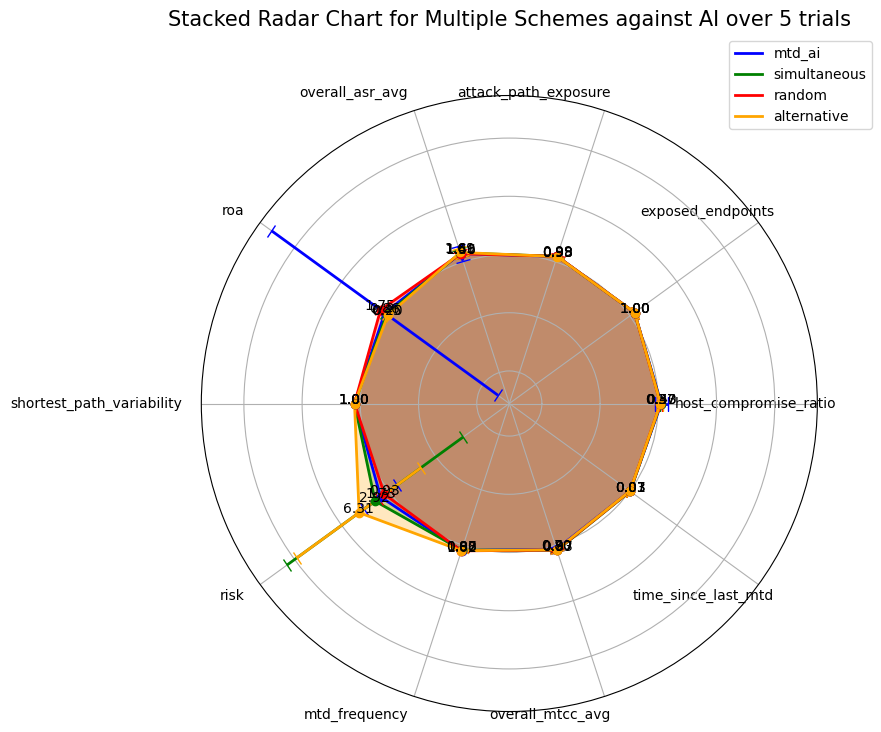

MTD: IPShuffle triggered 0.0s
MTD: CompleteTopologyShuffle triggered 100.2s
MTD: Interrupted EXPLOIT_VULN at 110.2s!
MTD: CompleteTopologyShuffle triggered 200.7s
MTD: IPShuffle triggered 300.7s
MTD: Interrupted EXPLOIT_VULN at 321.2s!
MTD: IPShuffle triggered 401.8s
MTD: CompleteTopologyShuffle triggered 502.0s
MTD: Interrupted EXPLOIT_VULN at 511.8s!
MTD: CompleteTopologyShuffle triggered 602.4s
MTD: CompleteTopologyShuffle triggered 702.7s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.65647585 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.65137622 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.65475346 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.3

MTD: Interrupted SCAN_PORT at 722.6s!
MTD: CompleteTopologyShuffle triggered 803.9s
MTD: OSDiversity triggered 904.2s
MTD: Interrupted EXPLOIT_VULN at 923.9s!
MTD: OSDiversity triggered 1005.4s
MTD: ServiceDiversity triggered 1105.6s
MTD: CompleteTopologyShuffle triggered 1205.6s
MTD: IPShuffle triggered 1305.9s


{'record name': 'Vulnerabilities Exploited', 'x': [279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 688.3266643539529, 688.3266643539529, 688.3266643539529, 688.3266643539529, 688.3266643539529], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'roa': [1.52292131183767, 0.376211063151951, 0.17008925165691027, 0.5214146878675152, 19.502063010304436, 12.821877719749537, 10.099609556243175, 10.737491012265698, 8.87175029316908, 5.1357951790804846, 2.729646199867217, 6.136271724126627, 1.7176852299689362, 1.6003172428349963, 1.4240771203343663, 1.775970461165682, 0.9834018312557946, 0.6849601808415253, 1.3550793791455735, 0.8897674697603412], 'impact': [6.377653780368951, 1.8632819562253178

MTD: Interrupted EXPLOIT_VULN at 1325.8s!
MTD: IPShuffle triggered 1406.2s
MTD: ServiceDiversity triggered 1506.3s
MTD: Interrupted SCAN_NEIGHBOR at 1516.3s!
MTD: ServiceDiversity triggered 1606.5s
MTD: CompleteTopologyShuffle triggered 1706.7s
MTD: OSDiversity triggered 1807.0s
MTD: Interrupted EXPLOIT_VULN at 1826.8s!


{'record name': 'Vulnerabilities Exploited', 'x': [279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 688.3266643539529, 688.3266643539529, 688.3266643539529, 688.3266643539529, 688.3266643539529, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'roa': [1.52292131183767, 0.376211063151951, 0.17008925165691027, 0.5214146878675152, 19.502063010304436, 12.821877719749537, 10.099609556243175, 10.737491012265698, 8.87175029316908, 5.1357951790804846, 2.7296

MTD: IPShuffle triggered 1909.3s
MTD: CompleteTopologyShuffle triggered 2011.6s
MTD: Interrupted EXPLOIT_VULN at 2019.9s!
MTD: CompleteTopologyShuffle triggered 2111.8s
MTD: IPShuffle triggered 2212.0s
MTD: Interrupted EXPLOIT_VULN at 2233.1s!
MTD: IPShuffle triggered 2312.3s
MTD: ServiceDiversity triggered 2412.4s
MTD: Interrupted EXPLOIT_VULN at 2422.7s!
MTD: ServiceDiversity triggered 2513.4s
MTD: OSDiversity triggered 2613.7s
MTD: IPShuffle triggered 2713.8s


{'record name': 'Vulnerabilities Exploited', 'x': [279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 688.3266643539529, 688.3266643539529, 688.3266643539529, 688.3266643539529, 688.3266643539529, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1410.6627517218967, 1410.6627517218967, 1410.6627517218967, 1410.6627517218967, 1410.6627517218967, 1410.6627517218967, 1460.276267485596, 1516.1335939587368, 1516.1335939587368], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 

MTD: ServiceDiversity triggered 2814.2s
MTD: Interrupted EXPLOIT_VULN at 2824.2s!
MTD: IPShuffle triggered 2914.4s


{'record name': 'Vulnerabilities Exploited', 'x': [279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 279.38414543525477, 688.3266643539529, 688.3266643539529, 688.3266643539529, 688.3266643539529, 688.3266643539529, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1264.5873293160564, 1410.6627517218967, 1410.6627517218967, 1410.6627517218967, 1410.6627517218967, 1410.6627517218967, 1410.6627517218967, 1460.276267485596, 1516.1335939587368, 1516.1335939587368, 2328.1523921165744, 2328.1523921165744, 2328.1523921165744, 2328.1523921165744, 2660.468311938778, 2660.468311938778, 2660.468311938778], 'cumulative exploited vulns': [1, 2, 

MTD: IPShuffle triggered 0.0s
MTD: OSDiversity triggered 100.6s
MTD: Interrupted SCAN_PORT at 110.3s!
MTD: OSDiversity triggered 201.4s
MTD: CompleteTopologyShuffle triggered 301.7s
MTD: IPShuffle triggered 402.3s
MTD: Interrupted EXPLOIT_VULN at 421.7s!
MTD: IPShuffle triggered 502.4s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22025661 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'roa': [10.287505892392186, 9.446854289741395, 5.46316560625166, 3.2434577294234246, 2.4969021738184995, 9.948765597410787, 1.6223161797268368, 6.39748952188899, 1.720969044709091, 0.6425131549542225], 'impact': [8.906865650635932, 5.227381937176877, 1.3137692981369697, 9.456285970847308, 6.306548228671442, 4.204203296343901, 3.5105820548169406, 4.171894025780496, 2.177437517019223, 3.0010366695783053], 

MTD: ServiceDiversity triggered 602.9s
MTD: Interrupted EXPLOIT_VULN at 613.8s!
MTD: CompleteTopologyShuffle triggered 703.5s
MTD: ServiceDiversity triggered 803.7s
MTD: Interrupted EXPLOIT_VULN at 824.7s!
MTD: OSDiversity triggered 904.3s
MTD: IPShuffle triggered 1004.9s
MTD: CompleteTopologyShuffle triggered 1105.1s
MTD: Interrupted EXPLOIT_VULN at 1115.4s!
MTD: CompleteTopologyShuffle triggered 1205.8s
MTD: ServiceDiversity triggered 1306.0s


{'record name': 'Vulnerabilities Exploited', 'x': [88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'roa': [10.287505892392186, 9.446854289741395, 5.46316560625166, 3.2434577294234246, 2.4969021738184995, 9.948765597410787, 1.6223161797268368, 6.39748952188899, 1.720969044709091, 0.6425131549542225, 61.94338968010895, 4.0430590975734235, 1.085021781003241, 56.108534543192846, 21.8767503413508, 6.186416944929589, 2.4517561282921085, 2.1464003847362765, 1.6984367641667921], 'impact': [8.906865650635932, 5.227381937176877, 1.3137692981369697, 9.456285970847308, 6.306548228671

MTD: Interrupted SCAN_PORT at 1325.9s!
MTD: ServiceDiversity triggered 1406.2s
MTD: OSDiversity triggered 1506.6s
MTD: ServiceDiversity triggered 1606.8s
MTD: IPShuffle triggered 1707.1s
MTD: ServiceDiversity triggered 1808.1s
MTD: Interrupted EXPLOIT_VULN at 1817.3s!
MTD: IPShuffle triggered 1909.6s
MTD: IPShuffle triggered 2010.1s
MTD: Interrupted EXPLOIT_VULN at 2020.2s!
MTD: IPShuffle triggered 2110.3s


{'record name': 'Vulnerabilities Exploited', 'x': [88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], 'roa': [10.287505892392186, 9.446854289741395, 5.46316560625166, 3.2434577294234246, 2.4969021738184995, 9.948765597410787, 1.6223161797268368, 6.39748952188899, 1.720969044709091, 0.6425131549542225, 61.94338968010895, 4.0430590975734235, 1.085021781003241, 56.108534543192846, 21.87675

MTD: IPShuffle triggered 2210.5s
MTD: Interrupted EXPLOIT_VULN at 2220.4s!
MTD: IPShuffle triggered 2310.7s
MTD: OSDiversity triggered 2411.0s
MTD: Interrupted EXPLOIT_VULN at 2422.8s!
MTD: CompleteTopologyShuffle triggered 2511.1s
MTD: OSDiversity triggered 2613.3s
MTD: Interrupted BRUTE_FORCE at 2631.2s!


{'record name': 'Vulnerabilities Exploited', 'x': [88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1952.057794997414, 2107.2064919249833, 2107.2064919249833], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'roa': [10.287505892392186, 9.446854289741395, 5.46316560625166, 3.2434577294234246, 2.4969021738184995, 9.948765597410787, 1.6223161797268368, 6.39748952188899, 1.720969044709091, 0.6425131549542225, 61.943389680108

MTD: IPShuffle triggered 2713.8s
MTD: OSDiversity triggered 2814.3s
MTD: Interrupted EXPLOIT_VULN at 2824.1s!
MTD: IPShuffle triggered 2914.8s


{'record name': 'Vulnerabilities Exploited', 'x': [88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 88.01617821667283, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 379.71300144471144, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1227.4605911679964, 1952.057794997414, 2107.2064919249833, 2107.2064919249833, 2572.8123925771797, 2572.8123925771797, 2572.8123925771797, 2572.8123925771797], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], 'roa': [10.287505892392186, 9.446854289741395, 5.46316560625166, 3.2434577294234246, 2.4969021738184995, 9.9487655974107

MTD: CompleteTopologyShuffle triggered 0.0s
MTD: CompleteTopologyShuffle triggered 100.1s
MTD: Interrupted ENUM_HOST at 120.8s!
MTD: CompleteTopologyShuffle triggered 200.3s
MTD: ServiceDiversity triggered 300.5s
MTD: Interrupted EXPLOIT_VULN at 321.4s!


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22357672 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.23049471 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22327513 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [223.58683033646767, 223.58683033646767, 223.58683033646767, 223.58683033646767], 'cum

MTD: CompleteTopologyShuffle triggered 401.6s
MTD: ServiceDiversity triggered 501.6s
MTD: Interrupted EXPLOIT_VULN at 522.0s!
MTD: CompleteTopologyShuffle triggered 601.7s
MTD: IPShuffle triggered 701.9s
MTD: Interrupted EXPLOIT_VULN at 722.3s!
MTD: IPShuffle triggered 802.4s


{'record name': 'Vulnerabilities Exploited', 'x': [223.58683033646767, 223.58683033646767, 223.58683033646767, 223.58683033646767], 'cumulative exploited vulns': [1, 2, 3, 4], 'roa': [13.28898691540953, 1.398610210337484, 8.773490920327513, 0.09948130403329089], 'impact': [6.480022996961504, 6.114337147480107, 8.210804213976884, 0.6978437486764688], 'risk': [6.084434520881842, 3.8627524083507865, 7.299907082609515, 0.3605850434541535], 'complexity': [0.938952612318636, 0.6317532571691336, 0.8890611555666144, 0.5167131526764257], 'total had os dependency': 2, 'total were dependent on another vuln': 0}
[3.33333333e-03 5.00000000e+00 2.13115079e-01 0.00000000e+00
 9.94813040e-02 0.00000000e+00 3.60585043e-01]
{'record name': 'Vulnerabilities Exploited', 'x': [223.58683033646767, 223.58683033646767, 223.58683033646767, 223.58683033646767, 477.2804194878199, 477.2804194878199, 477.2804194878199], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7], 'roa': [13.28898691540953, 1.3986102103374

MTD: IPShuffle triggered 903.9s
MTD: Interrupted SCAN_PORT at 913.4s!
MTD: IPShuffle triggered 1003.9s
MTD: CompleteTopologyShuffle triggered 1104.8s
MTD: Interrupted SCAN_PORT at 1114.1s!
MTD: CompleteTopologyShuffle triggered 1204.9s
MTD: OSDiversity triggered 1304.9s
MTD: Interrupted EXPLOIT_VULN at 1325.0s!


{'record name': 'Vulnerabilities Exploited', 'x': [223.58683033646767, 223.58683033646767, 223.58683033646767, 223.58683033646767, 477.2804194878199, 477.2804194878199, 477.2804194878199], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7], 'roa': [13.28898691540953, 1.398610210337484, 8.773490920327513, 0.09948130403329089, 27.06656085042363, 16.78476073333729, 0.3321378874878939], 'impact': [6.480022996961504, 6.114337147480107, 8.210804213976884, 0.6978437486764688, 8.802926509027468, 4.231760368260909, 3.422458633804184], 'risk': [6.084434520881842, 3.8627524083507865, 7.299907082609515, 0.3605850434541535, 8.43705901719911, 4.094132451094811, 1.4416964149035467], 'complexity': [0.938952612318636, 0.6317532571691336, 0.8890611555666144, 0.5167131526764257, 0.9584379704348139, 0.9674773840696802, 0.4212458262208563], 'total had os dependency': 3, 'total were dependent on another vuln': 0}
[0.01       5.         0.22459788 0.27272727 0.33213789 0.
 1.44169641]
{'record name': 'Vulne

MTD: CompleteTopologyShuffle triggered 1405.0s
MTD: CompleteTopologyShuffle triggered 1505.5s
MTD: Interrupted EXPLOIT_VULN at 1525.6s!
MTD: CompleteTopologyShuffle triggered 1605.6s
MTD: OSDiversity triggered 1705.6s
MTD: Interrupted EXPLOIT_VULN at 1725.8s!
MTD: OSDiversity triggered 1805.6s
MTD: OSDiversity triggered 1905.8s


{'record name': 'Vulnerabilities Exploited', 'x': [223.58683033646767, 223.58683033646767, 223.58683033646767, 223.58683033646767, 477.2804194878199, 477.2804194878199, 477.2804194878199, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 'roa': [13.28898691540953, 1.398610210337484, 8.773490920327513, 0.09948130403329089, 27.06656085042363, 16.78476073333729, 0.3321378874878939, 7.568791153197283, 1.502060957264808, 0.2282441109626

MTD: CompleteTopologyShuffle triggered 2006.6s
MTD: OSDiversity triggered 2106.9s
MTD: Interrupted EXPLOIT_VULN at 2126.9s!
MTD: CompleteTopologyShuffle triggered 2207.4s
MTD: IPShuffle triggered 2307.8s
MTD: Interrupted EXPLOIT_VULN at 2328.1s!
MTD: IPShuffle triggered 2408.5s


{'record name': 'Vulnerabilities Exploited', 'x': [223.58683033646767, 223.58683033646767, 223.58683033646767, 223.58683033646767, 477.2804194878199, 477.2804194878199, 477.2804194878199, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 'roa': [13.28898691540953, 1.398610210337484, 8.773490920327513, 0.09948130403329089, 27.06656085042363, 16.78476073333729, 0.3321378874878939, 7.568791153197283, 1.502060957264808, 0.2282441109626

MTD: IPShuffle triggered 2509.9s
MTD: Interrupted EXPLOIT_VULN at 2519.3s!
MTD: IPShuffle triggered 2610.8s
MTD: CompleteTopologyShuffle triggered 2711.4s
MTD: Interrupted EXPLOIT_VULN at 2720.9s!
MTD: CompleteTopologyShuffle triggered 2812.3s
MTD: ServiceDiversity triggered 2912.6s
MTD: Interrupted EXPLOIT_VULN at 2933.0s!


{'record name': 'Vulnerabilities Exploited', 'x': [223.58683033646767, 223.58683033646767, 223.58683033646767, 223.58683033646767, 477.2804194878199, 477.2804194878199, 477.2804194878199, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1086.348798805661, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 1287.5550831235144, 2452.470443320241, 2452.470443320241, 2452.470443320241, 2452.470443320241, 2452.470443320241], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], 'roa': [13.28898691540953, 1.398610210337484, 8.773490920327513, 0.099481304033290

MTD: CompleteTopologyShuffle triggered 0.0s
MTD: CompleteTopologyShuffle triggered 100.1s
MTD: Interrupted SCAN_PORT at 121.0s!
MTD: CompleteTopologyShuffle triggered 200.6s
MTD: ServiceDiversity triggered 301.1s
MTD: Interrupted EXPLOIT_VULN at 322.7s!
MTD: ServiceDiversity triggered 401.1s
MTD: IPShuffle triggered 501.7s
MTD: CompleteTopologyShuffle triggered 601.9s
MTD: Interrupted EXPLOIT_VULN at 612.3s!
MTD: CompleteTopologyShuffle triggered 703.0s
MTD: ServiceDiversity triggered 803.2s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.76666667 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.76666667 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22818519 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [203.83866013366463, 203.83866013366463, 203.83866013366463], 'cumulative exploited vu

MTD: Interrupted EXPLOIT_VULN at 823.8s!
MTD: OSDiversity triggered 903.6s
MTD: CompleteTopologyShuffle triggered 1004.0s
MTD: CompleteTopologyShuffle triggered 1104.1s
MTD: Interrupted EXPLOIT_VULN at 1124.0s!
MTD: CompleteTopologyShuffle triggered 1204.3s
MTD: IPShuffle triggered 1304.6s


{'record name': 'Vulnerabilities Exploited', 'x': [203.83866013366463, 203.83866013366463, 203.83866013366463], 'cumulative exploited vulns': [1, 2, 3], 'roa': [307.3491874884029, 25.24736424853794, 2.071085960886655], 'impact': [9.998209143957382, 7.183181783464185, 7.009691960355787], 'risk': [9.955030254463898, 6.920647352781156, 4.830029209616303], 'complexity': [0.9956813376403933, 0.9634515123524525, 0.6890501375714015], 'total had os dependency': 3, 'total were dependent on another vuln': 0}
[3.33333333e-03 5.00000000e+00 2.05981481e-01 0.00000000e+00
 2.07108596e+00 0.00000000e+00 4.83002921e+00]
{'record name': 'Vulnerabilities Exploited', 'x': [203.83866013366463, 203.83866013366463, 203.83866013366463], 'cumulative exploited vulns': [1, 2, 3], 'roa': [307.3491874884029, 25.24736424853794, 2.071085960886655], 'impact': [9.998209143957382, 7.183181783464185, 7.009691960355787], 'risk': [9.955030254463898, 6.920647352781156, 4.830029209616303], 'complexity': [0.9956813376403933

MTD: Interrupted EXPLOIT_VULN at 1325.6s!
MTD: IPShuffle triggered 1404.9s
MTD: OSDiversity triggered 1505.3s
MTD: Interrupted SCAN_PORT at 1515.1s!
MTD: OSDiversity triggered 1605.7s
MTD: IPShuffle triggered 1706.5s
MTD: OSDiversity triggered 1807.0s
MTD: Interrupted EXPLOIT_VULN at 1817.0s!
MTD: IPShuffle triggered 1907.3s
MTD: OSDiversity triggered 2007.6s
MTD: Interrupted EXPLOIT_VULN at 2018.1s!


{'record name': 'Vulnerabilities Exploited', 'x': [203.83866013366463, 203.83866013366463, 203.83866013366463], 'cumulative exploited vulns': [1, 2, 3], 'roa': [307.3491874884029, 25.24736424853794, 2.071085960886655], 'impact': [9.998209143957382, 7.183181783464185, 7.009691960355787], 'risk': [9.955030254463898, 6.920647352781156, 4.830029209616303], 'complexity': [0.9956813376403933, 0.9634515123524525, 0.6890501375714015], 'total had os dependency': 3, 'total were dependent on another vuln': 0}
[3.33333333e-03 5.00000000e+00 2.31347884e-01 0.00000000e+00
 2.07108596e+00 0.00000000e+00 4.83002921e+00]
{'record name': 'Vulnerabilities Exploited', 'x': [203.83866013366463, 203.83866013366463, 203.83866013366463, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1488.1598796234496, 1488.1598796234496, 1488.1598796234496], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], '

MTD: ServiceDiversity triggered 2107.9s
MTD: OSDiversity triggered 2208.0s
MTD: OSDiversity triggered 2308.1s
MTD: ServiceDiversity triggered 2409.1s
MTD: IPShuffle triggered 2509.3s
MTD: IPShuffle triggered 2610.8s
MTD: Interrupted EXPLOIT_VULN at 2620.0s!


{'record name': 'Vulnerabilities Exploited', 'x': [203.83866013366463, 203.83866013366463, 203.83866013366463, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1488.1598796234496, 1488.1598796234496, 1488.1598796234496], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'roa': [307.3491874884029, 25.24736424853794, 2.071085960886655, 19.670908600723262, 4.341129913368885, 21.755403507372034, 17.89588437490297, 14.960623532450903, 4.9581800746491025, 3.292186854114385, 1.0848137698979934, 0.2069715254265598, 4.3666932586715825], 'impact': [9.998209143957382, 7.183181783464185, 7.009691960355787, 6.500505757601954, 2.9882637957561533, 7.194023301964382, 7.200991194849947, 6.6576868547044645, 6.935035770424926, 4.866778367992447, 6.8570802021063315, 0.8426682215581005, 2.8000325504186097], 'risk': [9.955030254463898, 6.920647352781156, 4.830029209616303, 6.226169988118909, 2

MTD: IPShuffle triggered 2710.8s
MTD: ServiceDiversity triggered 2810.8s
MTD: Interrupted EXPLOIT_VULN at 2821.0s!
MTD: IPShuffle triggered 2911.2s


{'record name': 'Vulnerabilities Exploited', 'x': [203.83866013366463, 203.83866013366463, 203.83866013366463, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1407.0153853945776, 1488.1598796234496, 1488.1598796234496, 1488.1598796234496, 2386.299815286123, 2386.299815286123, 2386.299815286123, 2386.299815286123, 2386.299815286123, 2386.299815286123, 2386.299815286123, 2448.1166377368313, 2448.1166377368313, 2448.1166377368313], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'roa': [307.3491874884029, 25.24736424853794, 2.071085960886655, 19.670908600723262, 4.341129913368885, 21.755403507372034, 17.89588437490297, 14.960623532450903, 4.9581800746491025, 3.292186854114385, 1.0848137698979934, 0.2069715254265598, 4.3666932586715825, 0.6751694801143135, 0.00218463974113064, 54.97178252214571, 49.85571550664717, 14.590843884876532, 3.446696338145568, 

MTD: CompleteTopologyShuffle triggered 0.0s
MTD: IPShuffle triggered 100.0s
MTD: Interrupted EXPLOIT_VULN at 120.2s!
MTD: IPShuffle triggered 201.0s
MTD: IPShuffle triggered 301.1s
MTD: Interrupted EXPLOIT_VULN at 311.2s!
MTD: IPShuffle triggered 401.2s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21370238 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21246958 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.        5.        0.2056336 0.        0.        0.        0.       ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity

MTD: OSDiversity triggered 502.5s
MTD: Interrupted EXPLOIT_VULN at 511.3s!
MTD: OSDiversity triggered 602.9s
MTD: OSDiversity triggered 703.2s
MTD: CompleteTopologyShuffle triggered 804.5s
MTD: IPShuffle triggered 904.8s


{'record name': 'Vulnerabilities Exploited', 'x': [396.4838438346866, 396.4838438346866, 396.4838438346866], 'cumulative exploited vulns': [1, 2, 3], 'roa': [0.9205314562399286, 0.8127154622952385, 0.39874125816476863], 'impact': [8.819039022699172, 8.98744913098395, 4.485323749544923], 'risk': [3.8724432144222294, 3.6320667732387255, 1.7942531912867496], 'complexity': [0.4391003605330484, 0.4041265458423891, 0.40002757693216523], 'total had os dependency': 2, 'total were dependent on another vuln': 0}
[3.33333333e-03 5.00000000e+00 2.11978836e-01 0.00000000e+00
 3.98741258e-01 0.00000000e+00 1.79425319e+00]
{'record name': 'Vulnerabilities Exploited', 'x': [396.4838438346866, 396.4838438346866, 396.4838438346866], 'cumulative exploited vulns': [1, 2, 3], 'roa': [0.9205314562399286, 0.8127154622952385, 0.39874125816476863], 'impact': [8.819039022699172, 8.98744913098395, 4.485323749544923], 'risk': [3.8724432144222294, 3.6320667732387255, 1.7942531912867496], 'complexity': [0.439100360

MTD: Interrupted EXPLOIT_VULN at 925.9s!
MTD: IPShuffle triggered 1005.4s
MTD: OSDiversity triggered 1105.8s
MTD: Interrupted EXPLOIT_VULN at 1115.6s!
MTD: CompleteTopologyShuffle triggered 1205.9s
MTD: IPShuffle triggered 1306.1s
MTD: Interrupted EXPLOIT_VULN at 1326.8s!
MTD: IPShuffle triggered 1406.5s
MTD: OSDiversity triggered 1507.2s
MTD: Interrupted EXPLOIT_VULN at 1516.9s!
MTD: ServiceDiversity triggered 1607.4s


{'record name': 'Vulnerabilities Exploited', 'x': [396.4838438346866, 396.4838438346866, 396.4838438346866, 889.4708709094878, 889.4708709094878, 889.4708709094878, 889.4708709094878, 889.4708709094878, 889.4708709094878], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'roa': [0.9205314562399286, 0.8127154622952385, 0.39874125816476863, 35.260368540379694, 2.0532298917918506, 2.457197849243611, 0.1732730819633018, 0.798004722251181, 0.2871840279962119], 'impact': [8.819039022699172, 8.98744913098395, 4.485323749544923, 9.038481527101238, 9.671332007157202, 8.326363705302652, 0.6689552183321545, 5.827471771571158, 1.17512863659471], 'risk': [3.8724432144222294, 3.6320667732387255, 1.7942531912867496, 8.73977306883774, 5.940474898805783, 5.735168342969904, 0.44162459784552854, 2.9526013730456846, 0.7603122824809931], 'complexity': [0.4391003605330484, 0.4041265458423891, 0.40002757693216523, 0.9669514777047624, 0.6142354428955159, 0.6887962796193321, 0.6601706448252114, 0.506

MTD: IPShuffle triggered 1707.7s
MTD: OSDiversity triggered 1808.4s
MTD: Interrupted EXPLOIT_VULN at 1817.8s!
MTD: OSDiversity triggered 1909.2s
MTD: ServiceDiversity triggered 2009.4s
MTD: CompleteTopologyShuffle triggered 2111.2s
MTD: CompleteTopologyShuffle triggered 2212.1s


{'record name': 'Vulnerabilities Exploited', 'x': [396.4838438346866, 396.4838438346866, 396.4838438346866, 889.4708709094878, 889.4708709094878, 889.4708709094878, 889.4708709094878, 889.4708709094878, 889.4708709094878, 1279.27567844368, 1279.27567844368, 1397.9062924574878, 1397.9062924574878, 1397.9062924574878], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'roa': [0.9205314562399286, 0.8127154622952385, 0.39874125816476863, 35.260368540379694, 2.0532298917918506, 2.457197849243611, 0.1732730819633018, 0.798004722251181, 0.2871840279962119, 1.663276489152549, 1.2302757669156836, 5.463691286817572, 4.714931050828041, 0.7120104286789654], 'impact': [8.819039022699172, 8.98744913098395, 4.485323749544923, 9.038481527101238, 9.671332007157202, 8.326363705302652, 0.6689552183321545, 5.827471771571158, 1.17512863659471, 8.058242903919732, 4.859936883349993, 6.051640334353037, 4.584204556226533, 5.584737493270802], 'risk': [3.8724432144222294, 3.632066773

MTD: Interrupted EXPLOIT_VULN at 2231.5s!
MTD: CompleteTopologyShuffle triggered 2312.4s
MTD: OSDiversity triggered 2412.5s
MTD: Interrupted EXPLOIT_VULN at 2432.6s!
MTD: OSDiversity triggered 2513.1s
MTD: IPShuffle triggered 2613.7s
MTD: ServiceDiversity triggered 2713.9s
MTD: Interrupted EXPLOIT_VULN at 2724.4s!
MTD: ServiceDiversity triggered 2813.9s
MTD: IPShuffle triggered 2914.1s


{'record name': 'Vulnerabilities Exploited', 'x': [396.4838438346866, 396.4838438346866, 396.4838438346866, 889.4708709094878, 889.4708709094878, 889.4708709094878, 889.4708709094878, 889.4708709094878, 889.4708709094878, 1279.27567844368, 1279.27567844368, 1397.9062924574878, 1397.9062924574878, 1397.9062924574878, 2162.441825099142, 2162.441825099142, 2162.441825099142, 2162.441825099142], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 'roa': [0.9205314562399286, 0.8127154622952385, 0.39874125816476863, 35.260368540379694, 2.0532298917918506, 2.457197849243611, 0.1732730819633018, 0.798004722251181, 0.2871840279962119, 1.663276489152549, 1.2302757669156836, 5.463691286817572, 4.714931050828041, 0.7120104286789654, 0.7363293835589152, 1.7867853939670442, 1.6473003965496105, 0.9197766544620485], 'impact': [8.819039022699172, 8.98744913098395, 4.485323749544923, 9.038481527101238, 9.671332007157202, 8.326363705302652, 0.6689552183321545, 5

Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metri

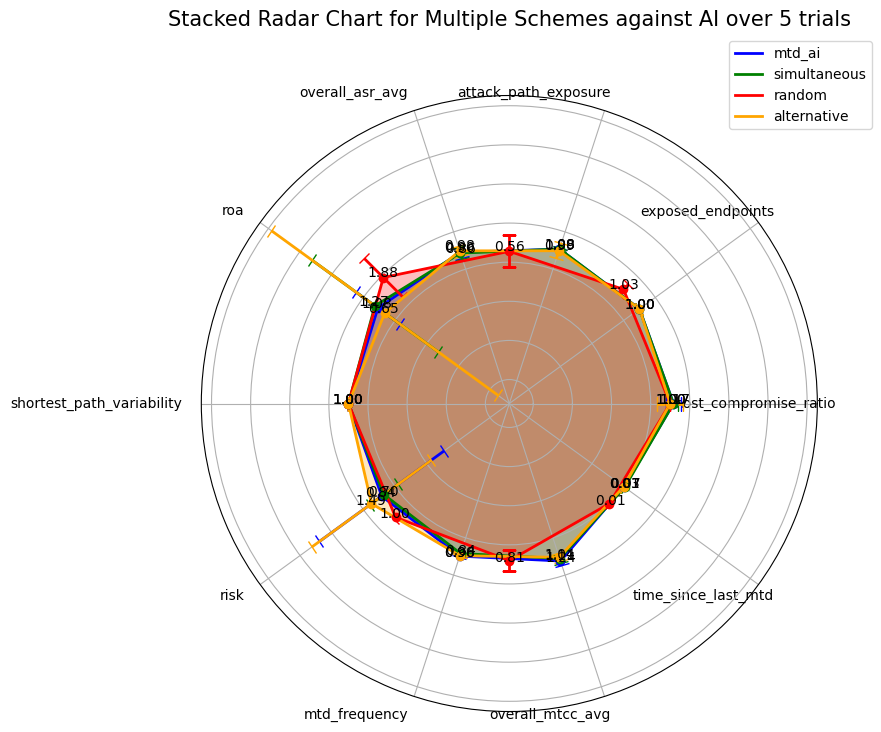

MTD: CompleteTopologyShuffle triggered 0.0s
MTD: ServiceDiversity triggered 100.4s
MTD: Interrupted EXPLOIT_VULN at 120.3s!
MTD: ServiceDiversity triggered 200.6s
MTD: OSDiversity triggered 300.7s
MTD: ServiceDiversity triggered 400.7s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.        5.        0.9025641 0.        0.        0.        0.       ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.        5.        0.9025641 0.        0.        0.        0.       ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.20588492 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity

MTD: CompleteTopologyShuffle triggered 501.1s
MTD: IPShuffle triggered 601.3s
MTD: Interrupted EXPLOIT_VULN at 621.2s!
MTD: IPShuffle triggered 701.6s
MTD: IPShuffle triggered 801.6s
MTD: Interrupted EXPLOIT_VULN at 811.7s!
MTD: IPShuffle triggered 901.7s
MTD: IPShuffle triggered 1001.7s
MTD: Interrupted EXPLOIT_VULN at 1011.9s!
MTD: IPShuffle triggered 1101.9s
MTD: OSDiversity triggered 1202.5s
MTD: Interrupted SCAN_NEIGHBOR at 1212.1s!


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22093519 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22313228 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22338228 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity

MTD: IPShuffle triggered 1302.6s
MTD: CompleteTopologyShuffle triggered 1403.3s
MTD: Interrupted EXPLOIT_VULN at 1413.2s!
MTD: CompleteTopologyShuffle triggered 1503.3s
MTD: OSDiversity triggered 1603.6s
MTD: Interrupted EXPLOIT_VULN at 1623.4s!
MTD: OSDiversity triggered 1704.3s
MTD: CompleteTopologyShuffle triggered 1805.7s
MTD: OSDiversity triggered 1906.2s
MTD: Interrupted EXPLOIT_VULN at 1925.9s!


{'record name': 'Vulnerabilities Exploited', 'x': [1209.8312647678842, 1209.8312647678842, 1209.8312647678842, 1209.8312647678842, 1209.8312647678842, 1209.8312647678842], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6], 'roa': [1.451775839255216, 0.03120136241851378, 0.6968554204600638, 0.18225907897005258, 73.75088303517444, 11.545594845460865], 'impact': [9.951391493694231, 0.2280109669694641, 7.51695343362456, 1.0996172464848686, 9.131190362730628, 9.92425878063401], 'risk': [5.199396802228729, 0.11548582151285129, 3.0829149515570635, 0.6093968899154816, 8.9828991446492, 8.903799087735624], 'complexity': [0.5224793744194832, 0.5064923983604591, 0.4101282492674069, 0.5541900073534971, 0.9837599248081953, 0.8971752233134338], 'total had os dependency': 4, 'total were dependent on another vuln': 0}
[3.33333333e-03 5.00000000e+00 1.91673280e-01 0.00000000e+00
 1.15455948e+01 0.00000000e+00 8.90379909e+00]
{'record name': 'Vulnerabilities Exploited', 'x': [1209.8312647678842, 1209.8312

MTD: CompleteTopologyShuffle triggered 2006.4s
MTD: OSDiversity triggered 2106.6s
MTD: Interrupted EXPLOIT_VULN at 2126.5s!
MTD: CompleteTopologyShuffle triggered 2206.8s
MTD: OSDiversity triggered 2307.3s
MTD: Interrupted EXPLOIT_VULN at 2326.9s!
MTD: CompleteTopologyShuffle triggered 2407.6s


{'record name': 'Vulnerabilities Exploited', 'x': [1209.8312647678842, 1209.8312647678842, 1209.8312647678842, 1209.8312647678842, 1209.8312647678842, 1209.8312647678842, 1517.836644698552, 1517.836644698552, 1517.836644698552, 1517.836644698552], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'roa': [1.451775839255216, 0.03120136241851378, 0.6968554204600638, 0.18225907897005258, 73.75088303517444, 11.545594845460865, 2.3318419275509, 1.2046232043383347, 0.039641660500260086, 1.6668531969838898], 'impact': [9.951391493694231, 0.2280109669694641, 7.51695343362456, 1.0996172464848686, 9.131190362730628, 9.92425878063401, 4.285150386727806, 8.110272992832066, 0.33309572216850714, 9.952039032493655], 'risk': [5.199396802228729, 0.11548582151285129, 3.0829149515570635, 0.6093968899154816, 8.9828991446492, 8.903799087735624, 3.4418260785931984, 4.273776564996453, 0.15709426094862783, 5.5409960171332555], 'complexity': [0.5224793744194832, 0.5064923983604591, 0.41012824926740

MTD: OSDiversity triggered 2508.4s
MTD: Interrupted EXPLOIT_VULN at 2527.9s!
MTD: CompleteTopologyShuffle triggered 2608.5s
MTD: IPShuffle triggered 2708.7s
MTD: Interrupted SCAN_PORT at 2728.8s!
MTD: IPShuffle triggered 2809.5s
MTD: CompleteTopologyShuffle triggered 2910.4s
MTD: Interrupted EXPLOIT_VULN at 2920.0s!


{'record name': 'Vulnerabilities Exploited', 'x': [1209.8312647678842, 1209.8312647678842, 1209.8312647678842, 1209.8312647678842, 1209.8312647678842, 1209.8312647678842, 1517.836644698552, 1517.836644698552, 1517.836644698552, 1517.836644698552], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'roa': [1.451775839255216, 0.03120136241851378, 0.6968554204600638, 0.18225907897005258, 73.75088303517444, 11.545594845460865, 2.3318419275509, 1.2046232043383347, 0.039641660500260086, 1.6668531969838898], 'impact': [9.951391493694231, 0.2280109669694641, 7.51695343362456, 1.0996172464848686, 9.131190362730628, 9.92425878063401, 4.285150386727806, 8.110272992832066, 0.33309572216850714, 9.952039032493655], 'risk': [5.199396802228729, 0.11548582151285129, 3.0829149515570635, 0.6093968899154816, 8.9828991446492, 8.903799087735624, 3.4418260785931984, 4.273776564996453, 0.15709426094862783, 5.5409960171332555], 'complexity': [0.5224793744194832, 0.5064923983604591, 0.41012824926740

MTD: ServiceDiversity triggered 0.0s
MTD: ServiceDiversity triggered 100.7s
MTD: ServiceDiversity triggered 201.0s
MTD: OSDiversity triggered 301.0s
MTD: OSDiversity triggered 401.2s
MTD: CompleteTopologyShuffle triggered 501.2s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.23893122 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22257275 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.23150529 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity

MTD: CompleteTopologyShuffle triggered 601.3s
MTD: Interrupted SCAN_PORT at 621.4s!
MTD: CompleteTopologyShuffle triggered 701.7s
MTD: ServiceDiversity triggered 802.2s
MTD: Interrupted EXPLOIT_VULN at 822.3s!
MTD: IPShuffle triggered 902.3s
MTD: OSDiversity triggered 1002.4s
MTD: Interrupted EXPLOIT_VULN at 1012.4s!
MTD: ServiceDiversity triggered 1102.8s
MTD: CompleteTopologyShuffle triggered 1204.6s
MTD: ServiceDiversity triggered 1305.8s
MTD: Interrupted EXPLOIT_VULN at 1325.1s!


{'record name': 'Vulnerabilities Exploited', 'x': [597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8], 'roa': [0.8008002651237398, 0.6023466602006381, 0.1023070722798437, 12.560657649079696, 9.002162400864146, 3.6883920602213176, 2.974041113202913, 1.2168669683987103], 'impact': [5.019346611900497, 4.1049830642642195, 0.3960522677301459, 1.7991179193024487, 1.0773832879295642, 3.351758459282681, 7.649941916506152, 4.275493916647497], 'risk': [2.734263271347778, 2.150709509915237, 0.261220374628415, 1.7654024116976619, 1.0604610863363304, 2.9895339282101143, 5.696307384757188, 2.9115293261290307], 'complexity': [0.5447448607882635, 0.5239265244814675, 0.6595603558225303, 0.9812599789913388, 0.9842932392001795, 0.8919300016773621, 0.7446209980322022, 0.68098081365346], 'total had os dependency': 3, 'total were dependent on another vu

MTD: IPShuffle triggered 1406.1s
MTD: CompleteTopologyShuffle triggered 1506.4s
MTD: Interrupted SCAN_NEIGHBOR at 1516.3s!
MTD: CompleteTopologyShuffle triggered 1606.8s
MTD: ServiceDiversity triggered 1706.9s
MTD: Interrupted EXPLOIT_VULN at 1727.0s!
MTD: ServiceDiversity triggered 1807.5s
MTD: IPShuffle triggered 1908.9s
MTD: IPShuffle triggered 2009.2s
MTD: Interrupted EXPLOIT_VULN at 2019.1s!


{'record name': 'Vulnerabilities Exploited', 'x': [597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 698.7357298075008, 698.7357298075008], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'roa': [0.8008002651237398, 0.6023466602006381, 0.1023070722798437, 12.560657649079696, 9.002162400864146, 3.6883920602213176, 2.974041113202913, 1.2168669683987103, 3.7511163649428654, 2.3651006350853745], 'impact': [5.019346611900497, 4.1049830642642195, 0.3960522677301459, 1.7991179193024487, 1.0773832879295642, 3.351758459282681, 7.649941916506152, 4.275493916647497, 8.942983209742653, 6.740348805860343], 'risk': [2.734263271347778, 2.150709509915237, 0.261220374628415, 1.7654024116976619, 1.0604610863363304, 2.9895339282101143, 5.696307384757188, 2.9115293261290307, 6.785895582132605, 4.884348242078275], 'complexity': [0.5447448607882635, 0.5239265244814675, 0.6595603558225303, 0.9

MTD: IPShuffle triggered 2109.9s
MTD: IPShuffle triggered 2210.3s
MTD: Interrupted EXPLOIT_VULN at 2220.2s!
MTD: IPShuffle triggered 2311.0s
MTD: OSDiversity triggered 2411.8s
MTD: Interrupted EXPLOIT_VULN at 2421.2s!
MTD: ServiceDiversity triggered 2512.0s


{'record name': 'Vulnerabilities Exploited', 'x': [597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 698.7357298075008, 698.7357298075008, 1514.4663888293892, 1514.4663888293892, 1514.4663888293892, 1514.4663888293892, 1650.1613046313012, 1650.1613046313012, 1650.1613046313012, 1650.1613046313012, 1829.8458261123967], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'roa': [0.8008002651237398, 0.6023466602006381, 0.1023070722798437, 12.560657649079696, 9.002162400864146, 3.6883920602213176, 2.974041113202913, 1.2168669683987103, 3.7511163649428654, 2.3651006350853745, 0.3856251939238831, 3.155413255250567, 1.4699292164650932, 0.5468713861147317, 20.450984461130133, 2.695313891968578, 0.7191997009086057, 4.5927141611178435, 0.8268067518120205], 'impact': [5.019346611900497, 4.1049830642642195, 0.3960522677301459, 1.7991179193024487, 1.07

MTD: IPShuffle triggered 2612.4s
MTD: ServiceDiversity triggered 2712.6s
MTD: Interrupted SCAN_NEIGHBOR at 2722.4s!
MTD: ServiceDiversity triggered 2812.9s
MTD: ServiceDiversity triggered 2913.4s


{'record name': 'Vulnerabilities Exploited', 'x': [597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 597.4826714503914, 698.7357298075008, 698.7357298075008, 1514.4663888293892, 1514.4663888293892, 1514.4663888293892, 1514.4663888293892, 1650.1613046313012, 1650.1613046313012, 1650.1613046313012, 1650.1613046313012, 1829.8458261123967, 2150.6471046525753, 2150.6471046525753, 2150.6471046525753, 2150.6471046525753, 2150.6471046525753, 2318.159017401349, 2318.159017401349, 2318.159017401349, 2318.159017401349, 2318.159017401349, 2318.159017401349, 2318.159017401349, 2318.159017401349], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], 'roa': [0.8008002651237398, 0.6023466602006381, 0.1023070722798437, 12.560657649079696, 9.002162400864146, 3.6883920602213176, 2.974041113202913, 1.2168669683987103, 3.7511163

MTD: CompleteTopologyShuffle triggered 0.0s
MTD: ServiceDiversity triggered 100.7s
MTD: Interrupted SCAN_PORT at 120.9s!
MTD: IPShuffle triggered 200.8s
MTD: OSDiversity triggered 301.6s
MTD: Interrupted EXPLOIT_VULN at 310.9s!
MTD: CompleteTopologyShuffle triggered 401.6s
MTD: OSDiversity triggered 502.5s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22110847 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22281349 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22470106 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [251.19543090501313, 251.19543090501313, 251.19543090501313, 251.19543090501313, 251.1

MTD: Interrupted EXPLOIT_VULN at 522.2s!
MTD: CompleteTopologyShuffle triggered 603.7s
MTD: ServiceDiversity triggered 703.7s
MTD: Interrupted EXPLOIT_VULN at 723.9s!
MTD: OSDiversity triggered 804.0s
MTD: OSDiversity triggered 904.1s


{'record name': 'Vulnerabilities Exploited', 'x': [251.19543090501313, 251.19543090501313, 251.19543090501313, 251.19543090501313, 251.19543090501313], 'cumulative exploited vulns': [1, 2, 3, 4, 5], 'roa': [3.0159950056878637, 0.8595343971258145, 2.970016328215662, 2.240822728685281, 1.8205442455891834], 'impact': [4.567666465539338, 5.211711311557935, 8.80051925394045, 7.645799361897302, 5.599057354490044], 'risk': [3.8002741734743952, 2.8818585167734123, 6.308241223195814, 5.255061589198473, 3.9707803790284877], 'complexity': [0.8319946743365529, 0.5529582021134511, 0.716803297756696, 0.687313561403007, 0.7091873020097224], 'total had os dependency': 3, 'total were dependent on another vuln': 0}
[3.33333333e-03 5.00000000e+00 2.41588624e-01 0.00000000e+00
 1.82054425e+00 0.00000000e+00 3.97078038e+00]
{'record name': 'Vulnerabilities Exploited', 'x': [251.19543090501313, 251.19543090501313, 251.19543090501313, 251.19543090501313, 251.19543090501313], 'cumulative exploited vulns': [1,

MTD: IPShuffle triggered 1004.2s
MTD: IPShuffle triggered 1104.2s
MTD: Interrupted EXPLOIT_VULN at 1115.3s!
MTD: IPShuffle triggered 1204.6s
MTD: ServiceDiversity triggered 1305.4s
MTD: Interrupted EXPLOIT_VULN at 1315.9s!
MTD: IPShuffle triggered 1405.6s
MTD: IPShuffle triggered 1505.7s
MTD: Interrupted EXPLOIT_VULN at 1515.9s!
MTD: IPShuffle triggered 1606.7s
MTD: IPShuffle triggered 1707.9s
MTD: Interrupted SCAN_PORT at 1717.0s!
MTD: IPShuffle triggered 1808.1s
MTD: IPShuffle triggered 1908.4s


{'record name': 'Vulnerabilities Exploited', 'x': [251.19543090501313, 251.19543090501313, 251.19543090501313, 251.19543090501313, 251.19543090501313, 837.1820165965444, 837.1820165965444, 837.1820165965444, 837.1820165965444], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'roa': [3.0159950056878637, 0.8595343971258145, 2.970016328215662, 2.240822728685281, 1.8205442455891834, 2.900979817355836, 0.5415410842228517, 20.40696992003235, 1.2827087747918362], 'impact': [4.567666465539338, 5.211711311557935, 8.80051925394045, 7.645799361897302, 5.599057354490044, 7.674234262335804, 1.3162835384020255, 7.793684702755944, 0.6017847598127102], 'risk': [3.8002741734743952, 2.8818585167734123, 6.308241223195814, 5.255061589198473, 3.9707803790284877, 5.673190970566151, 0.9941092425112161, 7.416046858543297, 0.5663571200006888], 'complexity': [0.8319946743365529, 0.5529582021134511, 0.716803297756696, 0.687313561403007, 0.7091873020097224, 0.7392517320469969, 0.7552394400662865, 0.951

MTD: Interrupted SCAN_PORT at 1919.0s!
MTD: IPShuffle triggered 2008.5s
MTD: IPShuffle triggered 2108.7s
MTD: Interrupted EXPLOIT_VULN at 2118.9s!
MTD: IPShuffle triggered 2209.2s
MTD: OSDiversity triggered 2309.4s
MTD: Interrupted EXPLOIT_VULN at 2320.0s!
MTD: CompleteTopologyShuffle triggered 2409.4s
MTD: ServiceDiversity triggered 2509.7s
MTD: Interrupted ENUM_HOST at 2530.3s!
MTD: ServiceDiversity triggered 2611.5s


{'record name': 'Vulnerabilities Exploited', 'x': [251.19543090501313, 251.19543090501313, 251.19543090501313, 251.19543090501313, 251.19543090501313, 837.1820165965444, 837.1820165965444, 837.1820165965444, 837.1820165965444, 1693.6478467457466, 1693.6478467457466, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'roa': [3.0159950056878637, 0.8595343971258145, 2.970016328215662, 2.240822728685281, 1.8205442455891834, 2.900979817355836, 0.5415410842228517, 20.40696992003235, 1.2827087747918362, 11.1704805880726, 0.3393968680495624, 31.856483584988222, 0.015315129934227775, 3.078373119767921, 2.4868020979132517, 0.7885650689077195, 0.2943508444054864, 1.87441083

MTD: CompleteTopologyShuffle triggered 2712.2s
MTD: OSDiversity triggered 2812.3s
MTD: Interrupted EXPLOIT_VULN at 2832.4s!
MTD: OSDiversity triggered 2912.6s


{'record name': 'Vulnerabilities Exploited', 'x': [251.19543090501313, 251.19543090501313, 251.19543090501313, 251.19543090501313, 251.19543090501313, 837.1820165965444, 837.1820165965444, 837.1820165965444, 837.1820165965444, 1693.6478467457466, 1693.6478467457466, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 1901.0810478043995, 2065.1046412178634, 2065.1046412178634, 2065.1046412178634, 2065.1046412178634, 2065.1046412178634, 2065.1046412178634, 2065.1046412178634, 2065.1046412178634, 2519.0079522280294, 2519.0079522280294, 2519.0079522280294, 2519.0079522280294, 2519.0079522280294, 2519.0079522280294, 2519.0079522280294, 2519.0079522280294], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33

MTD: IPShuffle triggered 0.0s
MTD: CompleteTopologyShuffle triggered 100.2s
MTD: Interrupted EXPLOIT_VULN at 110.6s!
MTD: CompleteTopologyShuffle triggered 200.7s
MTD: CompleteTopologyShuffle triggered 300.9s
MTD: Interrupted EXPLOIT_VULN at 320.9s!
MTD: CompleteTopologyShuffle triggered 401.6s
MTD: CompleteTopologyShuffle triggered 501.8s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22002646 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22064947 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22032407 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity

MTD: Interrupted EXPLOIT_VULN at 522.0s!
MTD: CompleteTopologyShuffle triggered 602.1s
MTD: IPShuffle triggered 702.5s
MTD: Interrupted EXPLOIT_VULN at 722.3s!
MTD: IPShuffle triggered 802.7s
MTD: OSDiversity triggered 903.1s
MTD: Interrupted EXPLOIT_VULN at 913.5s!
MTD: OSDiversity triggered 1003.6s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22192196 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22066799 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21601455 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity

MTD: CompleteTopologyShuffle triggered 1104.1s
MTD: IPShuffle triggered 1204.4s
MTD: Interrupted ENUM_HOST at 1224.6s!
MTD: IPShuffle triggered 1305.2s
MTD: CompleteTopologyShuffle triggered 1405.5s
MTD: Interrupted EXPLOIT_VULN at 1415.8s!
MTD: CompleteTopologyShuffle triggered 1506.3s
MTD: CompleteTopologyShuffle triggered 1607.0s
MTD: Interrupted EXPLOIT_VULN at 1626.7s!
MTD: CompleteTopologyShuffle triggered 1707.0s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21822619 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22036772 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [1216.5280638544023, 1216.5280638544023, 1216.5280638544023, 1216.5280638544023, 1216.5280638544023], 'cumulative exploited vulns': [1, 2, 3, 4, 5], 'roa': [0.37531131990743444, 0.5997300849160115, 0.44602279059891475, 7.061396024005527, 0.42181507427144804], 'impact': [3.1441051332348433, 3.8460601426820205, 0.6826821710927011, 8.435631650011949, 1.976394850943981], 'ris

MTD: IPShuffle triggered 1807.6s
MTD: Interrupted EXPLOIT_VULN at 1827.2s!
MTD: IPShuffle triggered 1907.7s
MTD: ServiceDiversity triggered 2007.8s
MTD: Interrupted EXPLOIT_VULN at 2017.8s!
MTD: OSDiversity triggered 2109.3s
MTD: ServiceDiversity triggered 2209.5s


{'record name': 'Vulnerabilities Exploited', 'x': [1216.5280638544023, 1216.5280638544023, 1216.5280638544023, 1216.5280638544023, 1216.5280638544023, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1709.7663698031959], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'roa': [0.37531131990743444, 0.5997300849160115, 0.44602279059891475, 7.061396024005527, 0.42181507427144804, 2.8792456978725296, 2.447290324079815, 2.095512694550945, 1.7881339995234695, 1.6154358944179183, 0.8766173436056491, 0.8558134591196838, 27.921823204813297, 27.283870269548167, 8.304601991533117, 4.827171333162077, 0.6069149397606209], 'impact': [3.1441051332348433, 3.8460601426820205, 0.6826821710927011, 8.435631650011949, 1.976394850943981, 1.7987818190460425, 6.937045693220188, 9.757121902805846, 3.6

MTD: IPShuffle triggered 2309.5s
MTD: ServiceDiversity triggered 2409.8s
MTD: Interrupted EXPLOIT_VULN at 2420.2s!
MTD: CompleteTopologyShuffle triggered 2510.1s
MTD: ServiceDiversity triggered 2610.7s
MTD: Interrupted EXPLOIT_VULN at 2631.5s!
MTD: ServiceDiversity triggered 2711.0s
MTD: ServiceDiversity triggered 2811.0s


{'record name': 'Vulnerabilities Exploited', 'x': [1216.5280638544023, 1216.5280638544023, 1216.5280638544023, 1216.5280638544023, 1216.5280638544023, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1709.7663698031959], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'roa': [0.37531131990743444, 0.5997300849160115, 0.44602279059891475, 7.061396024005527, 0.42181507427144804, 2.8792456978725296, 2.447290324079815, 2.095512694550945, 1.7881339995234695, 1.6154358944179183, 0.8766173436056491, 0.8558134591196838, 27.921823204813297, 27.283870269548167, 8.304601991533117, 4.827171333162077, 0.6069149397606209], 'impact': [3.1441051332348433, 3.8460601426820205, 0.6826821710927011, 8.435631650011949, 1.976394850943981, 1.7987818190460425, 6.937045693220188, 9.757121902805846, 3.6

MTD: OSDiversity triggered 2911.1s


{'record name': 'Vulnerabilities Exploited', 'x': [1216.5280638544023, 1216.5280638544023, 1216.5280638544023, 1216.5280638544023, 1216.5280638544023, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1560.6499627091616, 1709.7663698031959, 2575.7494367900995, 2575.7494367900995, 2575.7494367900995, 2575.7494367900995], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 'roa': [0.37531131990743444, 0.5997300849160115, 0.44602279059891475, 7.061396024005527, 0.42181507427144804, 2.8792456978725296, 2.447290324079815, 2.095512694550945, 1.7881339995234695, 1.6154358944179183, 0.8766173436056491, 0.8558134591196838, 27.921823204813297, 27.283870269548167, 8.304601991533117, 4.827171333162077, 0.6069149397606209, 3.3934481653327406, 1.7263556810729213, 2.8142969821058874, 0.4249938856561

MTD: ServiceDiversity triggered 0.0s
MTD: OSDiversity triggered 101.3s
MTD: OSDiversity triggered 201.5s
MTD: IPShuffle triggered 301.7s
MTD: OSDiversity triggered 402.8s
MTD: Interrupted EXPLOIT_VULN at 412.7s!
MTD: ServiceDiversity triggered 503.4s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21546693 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22057804 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22851323 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity

MTD: CompleteTopologyShuffle triggered 603.9s
MTD: OSDiversity triggered 704.1s
MTD: Interrupted EXPLOIT_VULN at 723.9s!
MTD: ServiceDiversity triggered 804.3s
MTD: OSDiversity triggered 904.6s
MTD: ServiceDiversity triggered 1005.0s


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.22167989 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21756085 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.20769312 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity

MTD: ServiceDiversity triggered 1105.3s
MTD: CompleteTopologyShuffle triggered 1205.8s
MTD: CompleteTopologyShuffle triggered 1305.8s
MTD: Interrupted EXPLOIT_VULN at 1326.5s!
MTD: CompleteTopologyShuffle triggered 1406.4s
MTD: OSDiversity triggered 1506.8s
MTD: Interrupted EXPLOIT_VULN at 1526.7s!


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.24187037 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21378704 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.21683333 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity

MTD: IPShuffle triggered 1607.5s
MTD: IPShuffle triggered 1707.6s
MTD: Interrupted EXPLOIT_VULN at 1717.5s!
MTD: IPShuffle triggered 1808.3s
MTD: OSDiversity triggered 1908.6s
MTD: Interrupted SCAN_PORT at 1918.3s!
MTD: ServiceDiversity triggered 2009.6s
MTD: IPShuffle triggered 2109.7s
MTD: OSDiversity triggered 2210.4s
MTD: Interrupted EXPLOIT_VULN at 2221.1s!
MTD: IPShuffle triggered 2310.4s
MTD: IPShuffle triggered 2410.8s
MTD: Interrupted EXPLOIT_VULN at 2420.5s!


{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.        5.        0.2089537 0.        0.        0.        0.       ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.20730026 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [], 'cumulative exploited vulns': [], 'roa': [], 'impact': [], 'risk': [], 'complexity': [], 'total had os dependency': 0, 'total were dependent on another vuln': 0}
[0.         5.         0.20962302 0.         0.         0.
 0.        ]
{'record name': 'Vulnerabilities Exploited', 'x': [1843.0825473245584, 1843.0825473245584, 1843.0825473245584, 1843.0825473245584, 1843.

MTD: IPShuffle triggered 2511.5s
MTD: OSDiversity triggered 2611.7s
MTD: Interrupted EXPLOIT_VULN at 2621.5s!
MTD: IPShuffle triggered 2712.0s
MTD: IPShuffle triggered 2812.4s
MTD: Interrupted EXPLOIT_VULN at 2822.3s!
MTD: IPShuffle triggered 2912.5s
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


{'record name': 'Vulnerabilities Exploited', 'x': [1843.0825473245584, 1843.0825473245584, 1843.0825473245584, 1843.0825473245584, 1843.0825473245584, 1843.0825473245584, 1843.0825473245584, 1843.0825473245584, 1888.7446180790978, 1888.7446180790978], 'cumulative exploited vulns': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'roa': [1.3387503800407592, 1.0997671048226232, 1.0065638673929258, 5.078440262221382, 1.34901166316869, 0.9422642318788932, 0.7804528196194102, 0.7557022876400891, 10.247447159138463, 2.2837916931493836], 'impact': [8.41291779157044, 5.815240066258273, 7.051028419610046, 5.902988164634378, 2.856851946756025, 1.3998489023964433, 4.035639191103191, 5.048750106943805, 9.879828677145731, 4.6444155983736515], 'risk': [4.577493036822513, 3.4106442677060382, 3.6458143657246582, 5.110893430249101, 2.227799485901741, 1.168407288348036, 2.388725905458876, 2.6701902620012934, 8.754443921739199, 3.653705012297433], 'complexity': [0.5441029081978028, 0.5865010264142999, 0.5170613630750744

Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metri

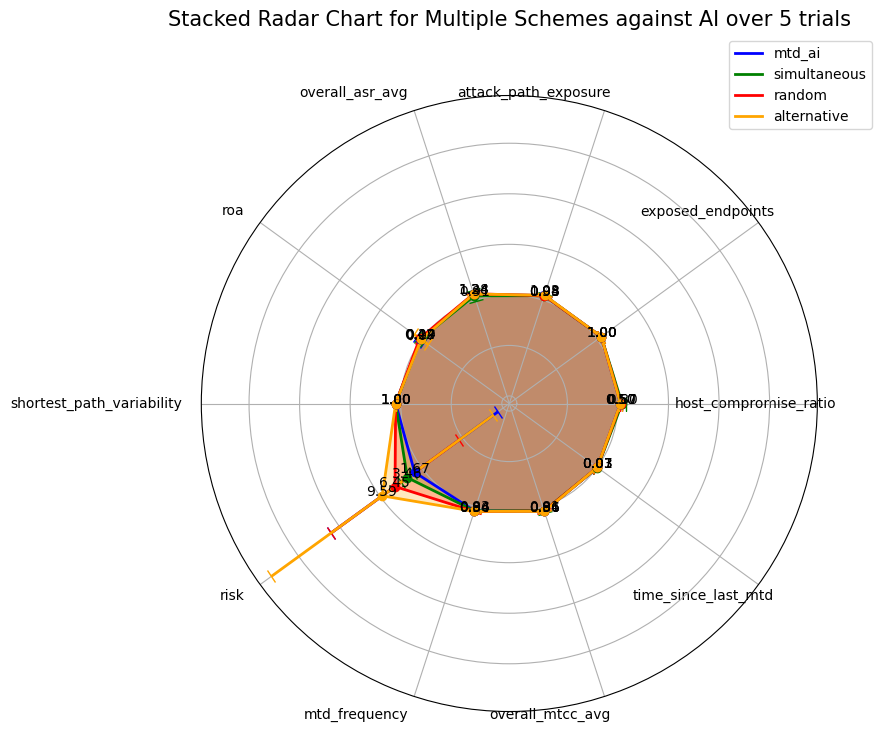

In [15]:
models =  ["main_network_all_features", "main_network_attack_path_exposure", "main_network_exposed_endpoints"]

for model in models:
    radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, total_nodes, new_network, features, model, trial=trial)
    # Plot against all schemes
    radar.plot_against_all_schemes()

